In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import vice
from imp import reload
import warnings
import scipy
import pandas as pd

import sys
sys.path.append("../..")


In [3]:
import src.yields
import src.analysis.vice_utils
import src.analysis.plotting_utils as pluto
import src.analysis.apogee_analysis as aah
from src.yields import amplified_yields
import src.analysis.gas_phase_data as gap

In [4]:
sf = pluto.fig_saver("../../figures")

In [5]:
def plot_data():
    gap.plot_gas()

Stellar yields

In [6]:
h07 = pd.DataFrame({
    "M": [9, 40, 60, 85],
    "m_C": [0.082, 1.79, 3.58, 7.89]
})

In [7]:
from vice.toolkit.interpolation import interp_scheme_1d

In [8]:
h07_m = interp_scheme_1d(h07.M.to_list(), h07.m_C.to_list())

In [9]:
from scipy.integrate import quad
imf = vice.imf.salpeter

m_min = 9
m_max = 100
m_minmin = 0.08
norm = quad(imf, m_minmin, m_max)[0]

In [10]:
int_yield = quad(lambda m: h07_m(m)*imf(m)/norm, m_min, 100)[0]

In [11]:
int_yield

0.001372864247282318

In [12]:
# (mass, rot, metallicity) from mm02 + h07 for low
z = [1e-8, 1e-5, 0.004, 0.02]
y = [int_yield, 4.9e-4, 3.3e-4, 4.4e-4]

In [30]:
vice.yields.ccsne.settings["c"] = interp_scheme_1d(z, y)

In [14]:
tau_rise = 2
tau_sfh = 30
def insideout(t):
    return 3*(1-np.exp(-t/tau_rise)) * np.exp(-t/tau_sfh)

t_max = 13.2
M_T = 0.1 # solar mases
tau_scale = 5 # Gyr
def ifr(t):
    return M_T * (tau_scale *(1-np.exp(-t_max/tau_scale)))**(-1) *np.exp(-t/tau_scale)

A = 1.5
s_burst = 1
t_burst = 11.2
def lateburst(t):
    return sfh(t) * (1 + A * np.exp(-(t-t_burst)**2/(2*s_burst**2)))

In [15]:
sfr_0 = 10**-5
tau_star = 50
tau_star_q = 10**5  # Gyr

def burst(t, t0, dt):
    return (-tau_star_q + tau_star) * ((t < t0 + dt) & (t > t0))

def sfr(t):
    return 0.5*(t<9) +  (burst(t, 9, 1) + burst(t, 12.5, 1))

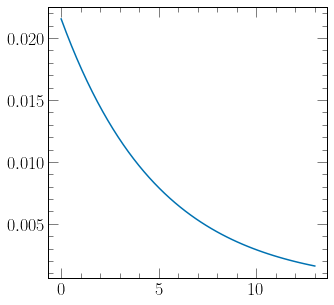

In [16]:
t = np.linspace(0, 13.)
plt.plot(t, ifr(t))

In [169]:

def sfr(t):
    return tau_star_q + (burst(t, 7, 0.15) + burst(t, 11, 0.15)
 + burst(t, 9, 0.15) + burst(t, 12.5, 0.15)) 


In [170]:
vice.yields.agb.settings["c"]  = "karakas16"
vice.yields.agb.settings["o"] = lambda m, z: 0
vice.yields.sneia.settings["o"] = 0
vice.yields.ccsne.settings["o"] = 4e-3

In [171]:
def show_line(out, x, y, ax=None, fig=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    f = ax.plot(out.history[x], out.history[y], **kwargs)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

In [172]:
def show(out, x, y, ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots()
    f = ax.scatter(out.history[x], out.history[y], c=out.history["time"], cmap="cool")
    fig.colorbar(f, ax=ax, label="t/Gyr")
    ax.set_xlabel(x)
    ax.set_ylabel(y)


In [173]:
tau_star = 2.5

In [195]:
vice.yields.ccsne.settings["o"] = 3*4e-3 
vice.yields.ccsne.settings["c"] = lambda x: 3*interp_scheme_1d(z, y)(x)
M_T = 0.01

In [196]:
model = vice.singlezone(func=ifr, mode="ifr", tau_star = sfr, dt=0.01, 
                        elements=("n", "o", "fe", "c"), schmidt=True,
                       eta=0.5, enhancement=2)


In [197]:
t_max = 13.2
out = model.run(np.linspace(0, t_max, round(100*t_max + 1)), 
                overwrite=True, capture=True)


(-2.0, -0.0644093956103382)

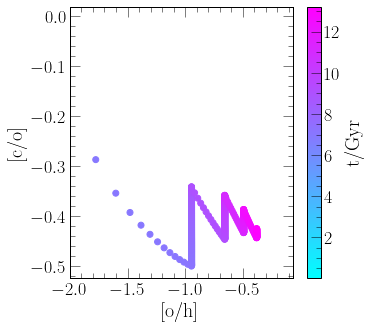

In [199]:
show(out, "[o/h]", "[c/o]")
plt.xlim(-2)

In [204]:

def y_c(z):
    return 0.004*(0.3 + 0.7*(z/0.014)**0.4)
vice.yields.ccsne.settings["c"] = y_c
vice.yields.agb.settings["c"]  = "cristallo11"
vice.yields.agb.settings["o"] = lambda m, z: 0
vice.yields.sneia.settings["o"] = 0
# vice.yields.ccsne.settings["o"] = 0.015

def tau_star2(t):
    return 10*(t < 3)
model2 = vice.singlezone(func=ifr, mode="ifr", dt=0.01, elements=("n", "o", "fe", "c"), schmidt=True, tau_star=tau_star2)


In [205]:
out2 = model2.run(np.linspace(0, t_max, round(100*t_max + 1)), overwrite=True, capture=True)

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/callback.py:119: ScienceWarning: Function <function callback1_nan_inf.__call__ at 0x2af0ea4c0d08> evaluated to NaN at (y_c, nan). Suppressing ArithmeticError by returning 0. Checking simulation output for numerical consistency is advised.
  str(function), str(args)), ScienceWarning)


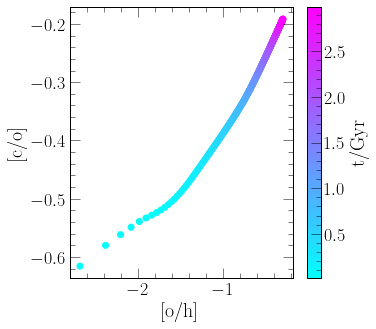

In [206]:
show(out2, "[o/h]", "[c/o]")

(-3.0, 0.6244537574555031)

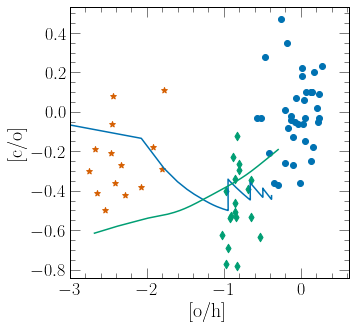

In [207]:
fig, ax = plt.subplots()
show_line(out, "[o/h]", "[c/o]", ax=ax)
show_line(out2, "[o/h]", "[c/o]", ax=ax)
plot_data()
plt.xlim(-3)